## Introduction
This notebook contains implementation of models for classifying whether review is fake or real.

In [26]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read\_from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
import numpy as np

from sklearn.model_selection import(
    cross_validate,
    train_test_split
)


In [3]:
import warnings
warnings.filterwarnings("ignore")

There is 1 csv file in the current version of the dataset:


In [28]:
# print(os.listdir('../input'))

Functions for plotting data.

In [5]:
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()


In [6]:
# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    filename = df.dataframeName
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()


In [7]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()


Understanding Data and Visualization

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
nRowsRead = 1000 # specify 'None' if want to read whole file
df1 = pd.read_csv('/content/drive/MyDrive/yelpDataset/cleaned_data.csv', delimiter=',', nrows = nRowsRead)
df1.dataframeName = 'cleaned_data.csv'
nRow, nCol = df1.shape
# print(f'There are {nRow} rows and {nCol} columns')
df1.head()

,Unnamed: 0,average_stars,review_count,compliment_cool,compliment_cute,compliment_funny,compliment_hot,compliment_list,compliment_more,compliment_note,...,VB,VBD,VBG,VBN,VBP,VBZ,WDT,WP,WRB,Faker
0,0,4.67,8,0,0,0,0,0,0,0,...,5.0,5.0,0.0,4.0,1.0,3.0,1.0,0.0,1.0,1
1,1,1.00,1,0,0,0,0,0,0,0,...,7.0,11.0,1.0,4.0,3.0,1.0,1.0,0.0,1.0,1
2,2,1.67,2,0,0,0,0,0,0,0,...,2.0,6.0,0.0,2.0,2.0,1.0,0.0,1.0,0.0,1
3,3,3.00,2,0,0,0,0,0,0,0,...,2.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1
4,4,3.73,48,1,0,1,2,0,0,1,...,14.0,15.0,3.0,10.0,6.0,16.0,1.0,2.0,1.0,1


Let's take a quick look at what the data looks like:

In [14]:
df1['Faker'].unique()
df1.head(5)

,Unnamed: 0,average_stars,review_count,compliment_cool,compliment_cute,compliment_funny,compliment_hot,compliment_list,compliment_more,compliment_note,...,VB,VBD,VBG,VBN,VBP,VBZ,WDT,WP,WRB,Faker
0,0,4.67,8,0,0,0,0,0,0,0,...,5.0,5.0,0.0,4.0,1.0,3.0,1.0,0.0,1.0,1
1,1,1.00,1,0,0,0,0,0,0,0,...,7.0,11.0,1.0,4.0,3.0,1.0,1.0,0.0,1.0,1
2,2,1.67,2,0,0,0,0,0,0,0,...,2.0,6.0,0.0,2.0,2.0,1.0,0.0,1.0,0.0,1
3,3,3.00,2,0,0,0,0,0,0,0,...,2.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1
4,4,3.73,48,1,0,1,2,0,0,1,...,14.0,15.0,3.0,10.0,6.0,16.0,1.0,2.0,1.0,1


In [15]:
df1.corr()

,Unnamed: 0,average_stars,review_count,compliment_cool,compliment_cute,compliment_funny,compliment_hot,compliment_list,compliment_more,compliment_note,...,VB,VBD,VBG,VBN,VBP,VBZ,WDT,WP,WRB,Faker
Unnamed: 0,1.000000,0.032963,-0.050835,-0.147150,NaN,-0.147150,-0.144909,NaN,-0.156252,-0.149003,...,-0.053219,-0.103305,-0.040983,-0.098694,-0.083364,-0.029681,0.013449,-0.072348,-0.015284,-0.588905
average_stars,0.032963,1.000000,-0.005812,0.036886,NaN,0.036886,0.054308,NaN,0.024785,-0.004040,...,-0.203073,-0.268635,-0.138327,-0.217430,-0.074477,-0.022505,-0.162498,-0.148216,-0.215943,-0.072845
review_count,-0.050835,-0.005812,1.000000,0.428153,NaN,0.428153,0.457043,NaN,0.232865,0.474174,...,0.242386,0.092185,0.199223,0.096223,0.337636,0.389807,0.221069,0.133313,0.299231,-0.013237
compliment_cool,-0.147150,0.036886,0.428153,1.000000,NaN,1.000000,0.769168,NaN,0.551812,0.655376,...,0.276054,0.158397,0.176398,0.153613,0.359420,0.371784,0.267252,0.226141,0.308410,0.087753
compliment_cute,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
compliment_funny,-0.147150,0.036886,0.428153,1.000000,NaN,1.000000,0.769168,NaN,0.551812,0.655376,...,0.276054,0.158397,0.176398,0.153613,0.359420,0.371784,0.267252,0.226141,0.308410,0.087753
compliment_hot,-0.144909,0.054308,0.457043,0.769168,NaN,0.769168,1.000000,NaN,0.377779,0.389199,...,0.386912,0.184963,0.217599,0.282969,0.454053,0.547629,0.366494,0.273921,0.349328,0.088648
compliment_list,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
compliment_more,-0.156252,0.024785,0.232865,0.551812,NaN,0.551812,0.377779,NaN,1.000000,0.746976,...,0.027153,0.020008,0.025622,0.022808,0.037898,0.008718,-0.028748,-0.050253,0.131445,0.114294
compliment_note,-0.149003,-0.004040,0.474174,0.655376,NaN,0.655376,0.389199,NaN,0.746976,1.000000,...,0.034807,0.030860,0.077574,-0.006171,0.032926,0.052170,-0.049901,0.040410,0.143057,0.063628


Distribution graphs (histogram/bar graph) of sampled columns:

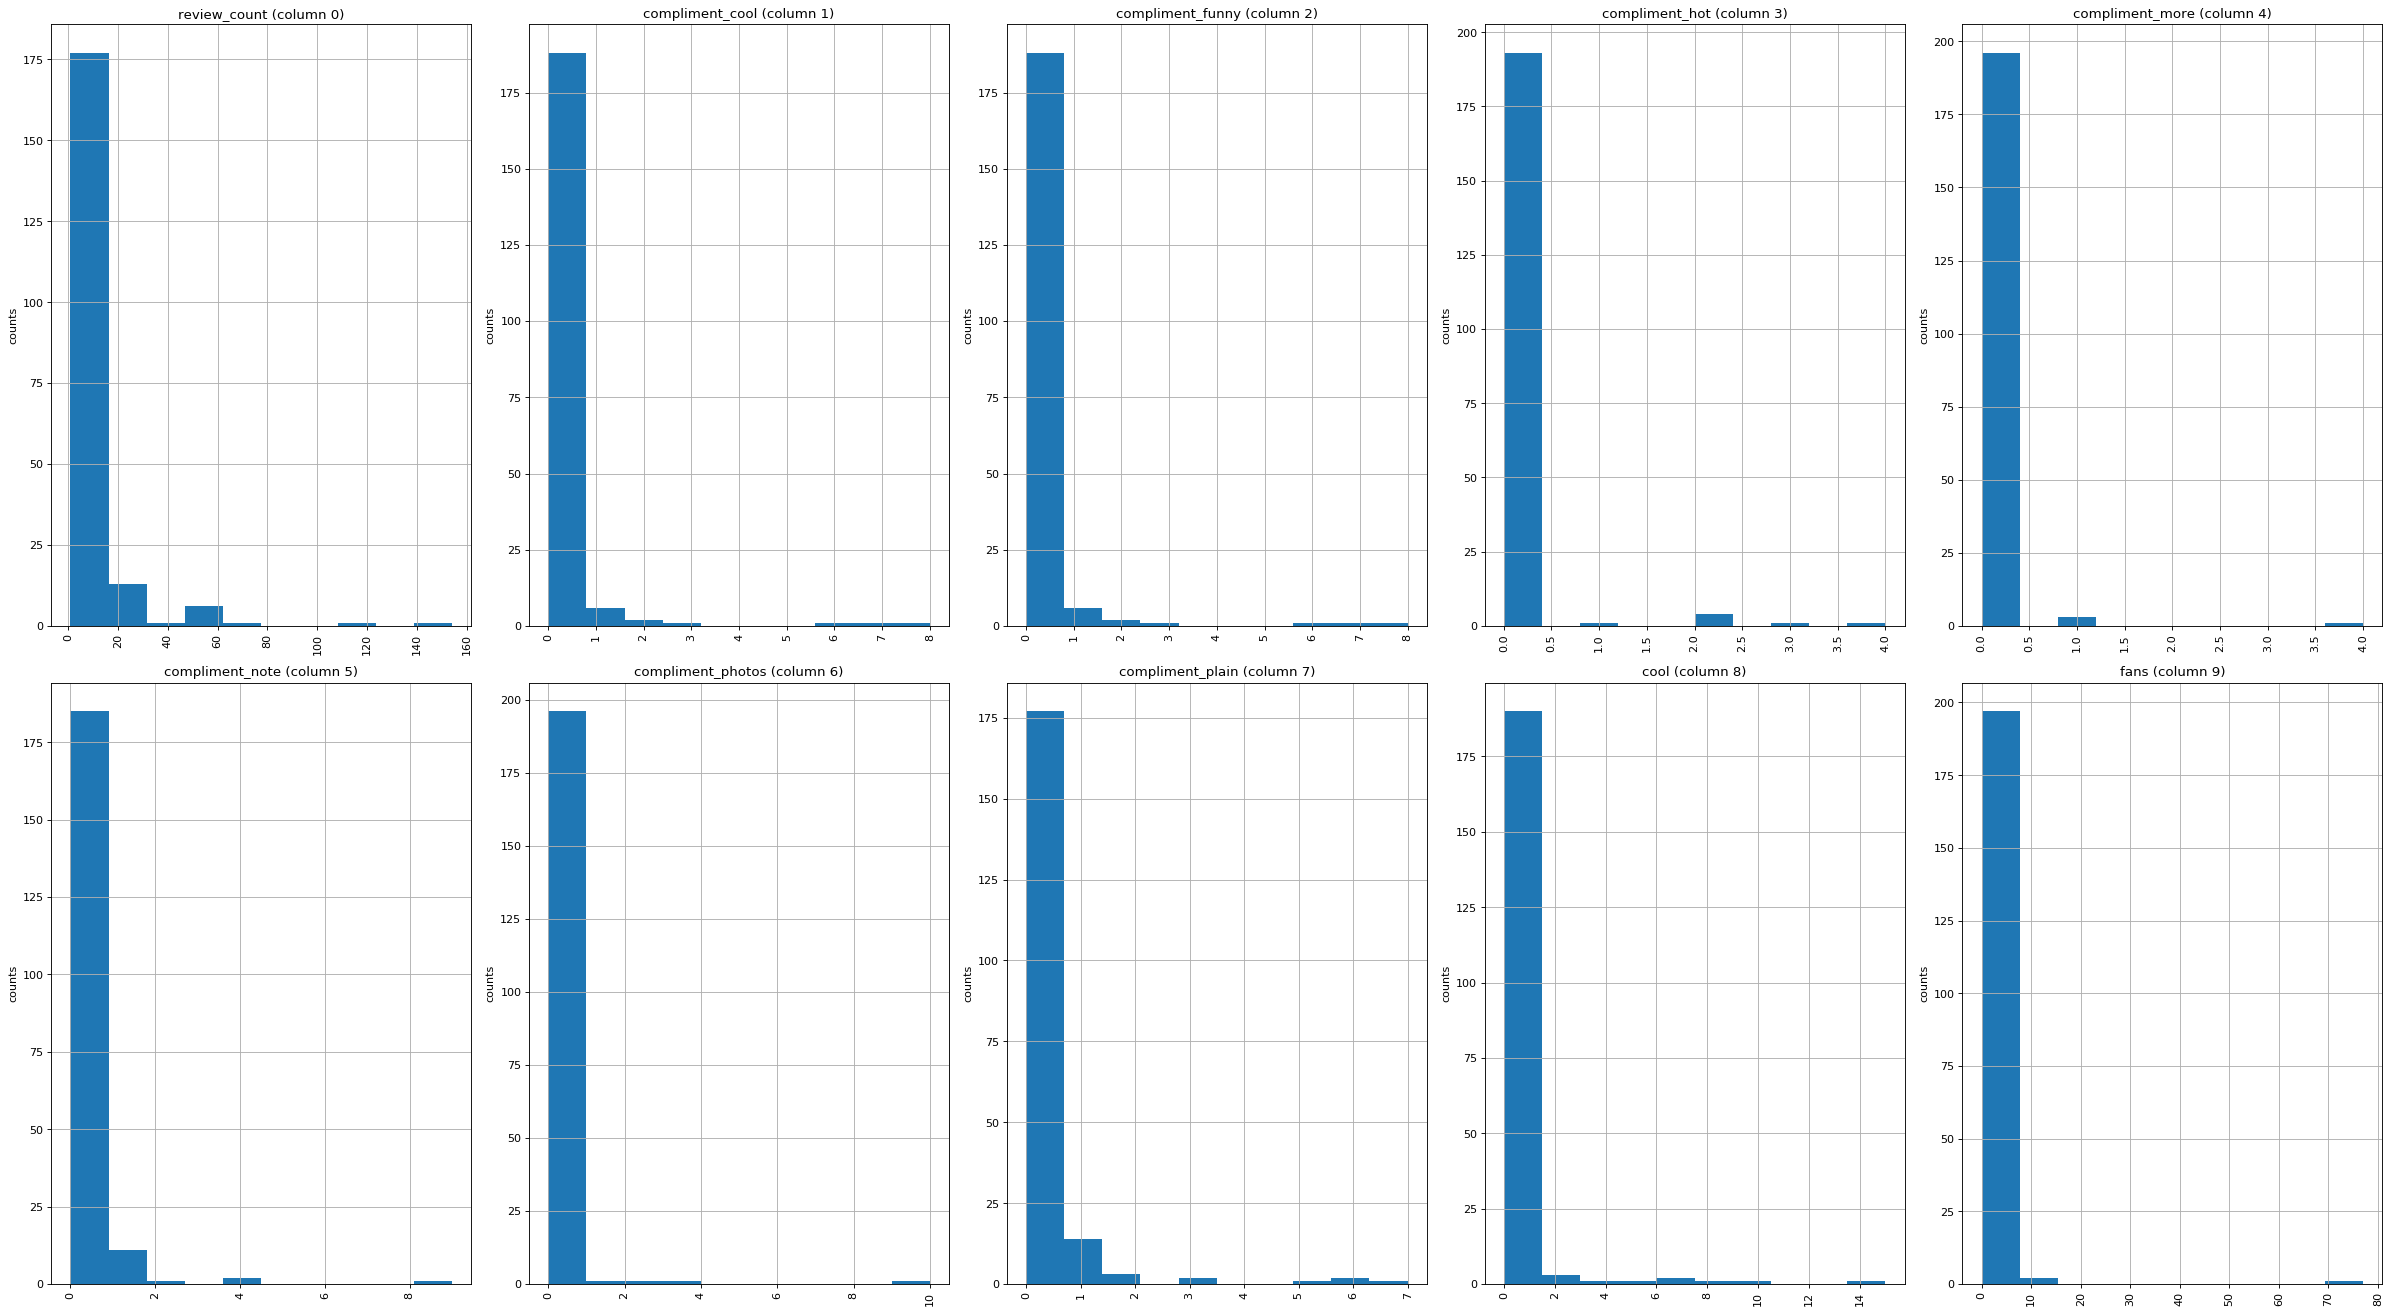

In [ ]:
plotPerColumnDistribution(df1, 10, 5)

Correlation matrix:

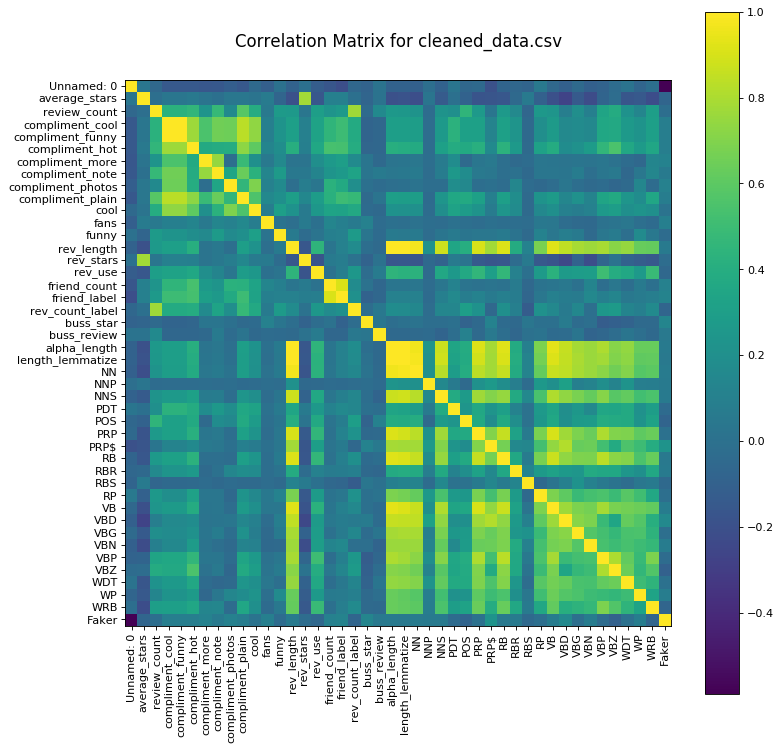

In [ ]:
plotCorrelationMatrix(df1, 11)

Scatter and density plots:

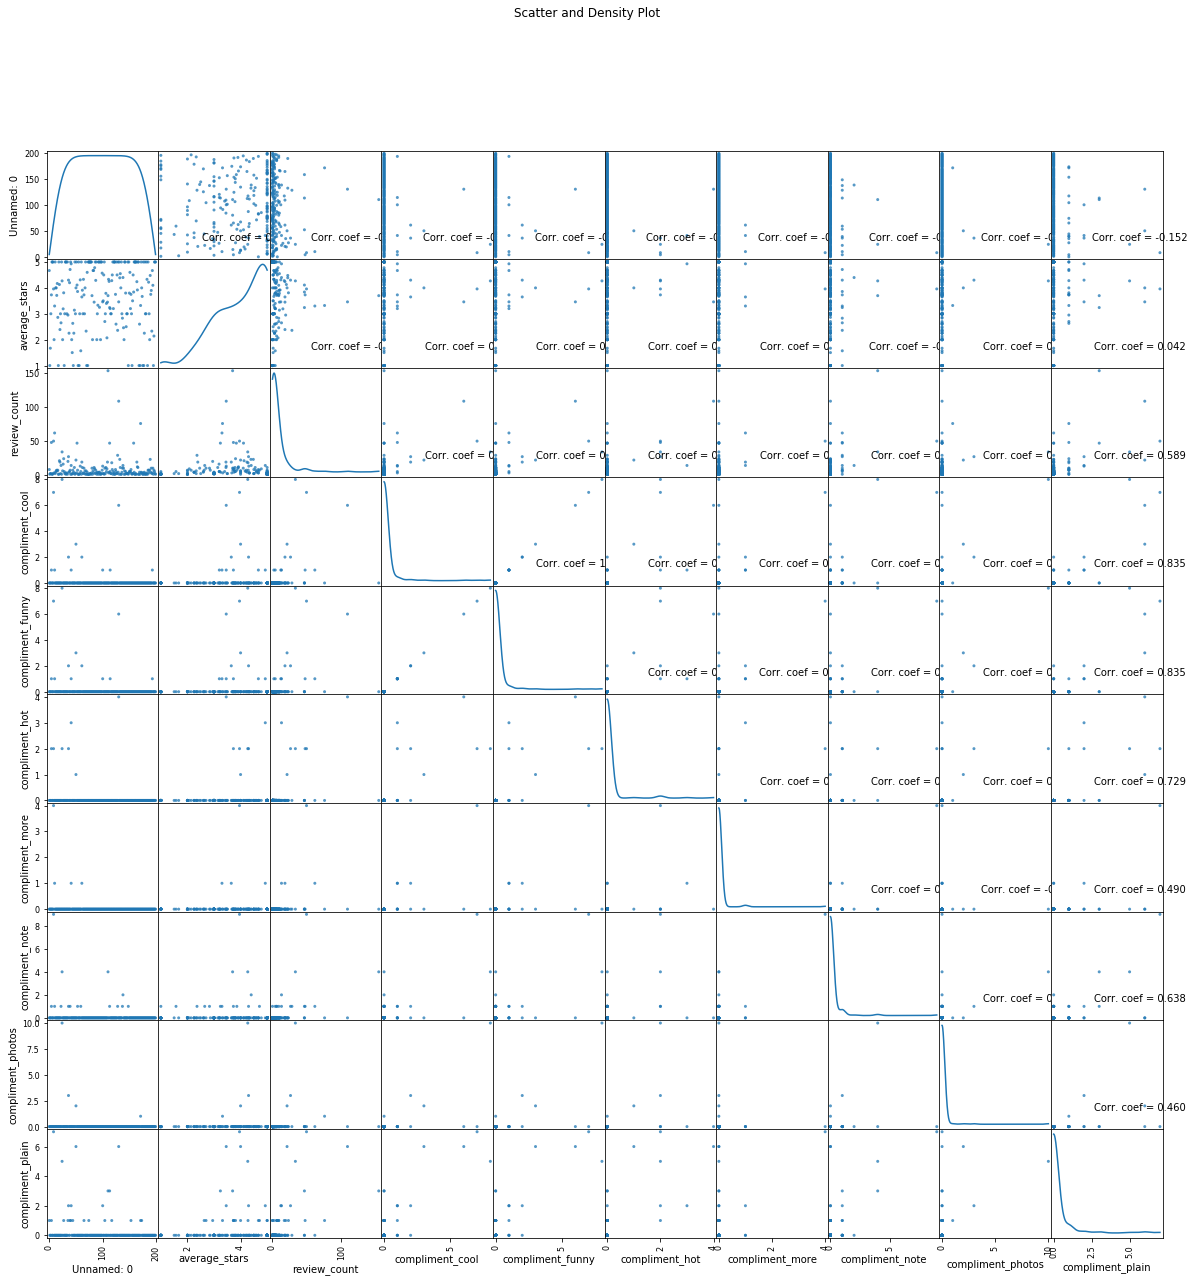

In [ ]:
plotScatterMatrix(df1, 20, 10)

Implementation of classification models and comparisions

In [19]:
X=  df1.drop("Faker", axis='columns')
y= df1['Faker']
X_train, X_test, Y_train, Y_test = train_test_split(X,y,
                                     test_size=0.3,
                                     random_state=2018)


In [21]:
def mean_cross_val_scores(model, X_train, y_train, **kwargs):
    
    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append(round(mean_scores[i], 3))

    return pd.Series(data=out_col, index=mean_scores.index)

In [23]:
models = {
    "decision tree": DecisionTreeClassifier(random_state=2018),
    "kNN": KNeighborsClassifier(),
    "RBF SVM": SVC(random_state=2018),
}

models_short = {
     "decision tree": 'DecisionTree',
    "kNN": 'kNN',
    'RBF SVM': 'SVC',
}

results_dict = {}
for i in models:
    pipe_temp = make_pipeline(models[i])
    results_dict[models_short[i]] = mean_cross_val_scores(
    pipe_temp, X_train, Y_train, cv=5, return_train_score=True)
    
print(pd.DataFrame(results_dict))

             DecisionTree    kNN    SVC
fit_time            0.005  0.004  0.006
score_time          0.003  0.005  0.004
test_score          0.986  0.686  0.586
train_score         1.000  0.812  0.629


Implying hyperparameter on SVC to increase efficiency

In [24]:
param_grid = {"C": np.logspace(-2, 2, 4)}

results_dict = {}
for i in param_grid["C"]:
    pipe_temp = make_pipeline(SVC(C=i, random_state=2018))
    results_dict[i] = mean_cross_val_scores(
    pipe_temp, X_train, Y_train, cv=5, return_train_score=True)
    
hyper_C = pd.DataFrame(results_dict).T
hyper_C.index.name='Hyperparameter: C'
print(hyper_C)

                   fit_time  score_time  test_score  train_score
Hyperparameter: C                                               
0.010000              0.005       0.002       0.529        0.529
0.215443              0.004       0.002       0.529        0.589
4.641589              0.004       0.002       0.764        0.821
100.000000            0.005       0.002       0.800        0.888


# Comparing various classification models

In [27]:
models = {
    "decision tree": DecisionTreeClassifier(random_state=2018),
    "kNN": KNeighborsClassifier(),
    "RBF SVM": SVC(random_state=2018),
    "LR" : LogisticRegression(random_state=0),
    "GB": GaussianNB(),
    "MNB" : MultinomialNB(),
    "SGDcl" : SGDClassifier(max_iter=1000, tol=1e-3)
    
    
}

models_short = {
     "decision tree": 'DecisionTree',
    "kNN": 'kNN',
    'RBF SVM': 'SVC',
    "LR" : 'logisticRegression',
    "GB": 'GaussianNB',
    "MNB" : 'MultinomialNB',
    "SGDcl" : 'SGDClassifier'
}

results_dict = {}
for i in models:
    pipe_temp = make_pipeline(models[i])
    results_dict[models_short[i]] = mean_cross_val_scores(
    pipe_temp, X_train, Y_train, cv=5, return_train_score=True)
    
pd.DataFrame(results_dict)

,DecisionTree,kNN,SVC,logisticRegression,GaussianNB,MultinomialNB,SGDClassifier
fit_time,0.004,0.003,0.006,0.042,0.003,0.003,0.003
score_time,0.002,0.004,0.004,0.003,0.002,0.002,0.002
test_score,0.986,0.686,0.586,0.757,0.571,0.686,0.607
train_score,1.000,0.812,0.629,0.859,0.655,0.682,0.580
